# QDAC-II 2D diode scan

In [1]:
from time import sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display
from qcodes_contrib_drivers.drivers.QDevil import QDAC2
qdac_addr = '192.168.8.17'
qdac = QDAC2.QDac2('QDAC2', visalib='@py', address=f'TCPIP::{qdac_addr}::5025::SOCKET')

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : /Users/jps/.qcodes/logs/command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : /Users/jps/.qcodes/logs/220421-5376-qcodes.log
Connected to: QDevil QDAC-II (serial:3, firmware:7-0.17.0) in 0.27s


In [2]:
qdac.reset()
sleep(3)

In [3]:
arrangement = qdac.arrange(
        # QDAC channels 2 & 3 connected to the ends of two back-to-back Ge diodes
        gates={'diodes_left': 2, 'diodes_right': 3},
        # Internal trigger for measuring current
        internal_triggers={'inner'})
inner_steps = 21
inner_V = np.linspace(-0.3, 0.4, inner_steps)
outer_steps = 21
outer_V = np.linspace(-0.2, 0.5, outer_steps)
sweep = arrangement.virtual_sweep2d(
        inner_gate='diodes_left',
        inner_voltages=inner_V,
        outer_gate='diodes_right',
        outer_voltages=outer_V,
        inner_step_time_s=20e-3,
        inner_step_trigger='inner')
qdac.errors()

'0, "No error"'

In [4]:
# Hook up current measurement to the internal trigger produced by the sweep
diodes = qdac.channel(2)
diodes.clear_measurements()
measurement = diodes.measurement()
measurement.start_on(arrangement.get_trigger_by_name('inner'))
qdac.errors()

'0, "No error"'

In [5]:
# Start sweep
sweep.start()
sleep(10)
# Stop current flow
qdac.channel(2).dc_constant_V(0)
qdac.channel(3).dc_constant_V(0)

In [6]:
sleep(3)
raw = measurement.available_A()
# Circumvent flaw in 0.12.0 driver
print(len(raw))
available = list(map(lambda x: float(x), raw[-(outer_steps * inner_steps):]))

442


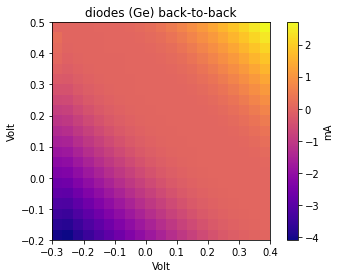

In [7]:
currents = np.reshape(available, (-1, inner_steps)) * 1000
fig, ax = plt.subplots()
plt.title('diodes (Ge) back-to-back')
extent = [inner_V[0],inner_V[-1],outer_V[0],outer_V[-1]]
img = ax.imshow(currents, cmap='plasma', interpolation='nearest', extent=extent)
ax.set_xlabel('Volt')
ax.set_ylabel('Volt')
colorbar = fig.colorbar(img)
colorbar.set_label('mA')